In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [7]:
!apt install -y ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [8]:
SOURCE_PATH = "drive/MyDrive/GTZAN/Data/genres_original"

JSON_PATH = 'drive/MyDrive/data.json'

sample_rate = 22050

TOTAL_SAMPLES = 29 * sample_rate

NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [9]:
def preprocess_data(source_path, json_path):
    genres_dict = {
          'blues': 0,
          'classical': 1,
          'country': 2,
          'disco': 3,
          'hiphop': 4,
          'jazz': 5,
          'metal': 6,
          'pop': 7,
          'reggae': 8,
          'rock': 9,
    }

    mydict = {
        "labels": [],
        "mfcc": []
        }

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(source_path)):
        print(i)
        print(dirpath)
        for file in filenames:
            # exclude corrupted wav file
            if os.path.join(dirpath, file) != SOURCE_PATH + '/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE
                    mfcc = librosa.feature.mfcc(y=song[start_sample:end_sample], sr=sr, n_mfcc=13)
                    mfcc = mfcc.T
                    mydict["labels"].append(genres_dict[file.split('.')[0]])
                    mydict["mfcc"].append(mfcc.tolist())
   
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [10]:
def load_data(json_path):

    with open(json_path, 'r') as f:
        data = json.load(f)
    f.close()

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return X, y

In [11]:
def prepare_datasets(inputs, targets, split_size):
    
    # Splitting sets
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # 3D input for CNN
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [12]:
def design_model(input_shape):

    model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'), 
        tf.keras.layers.Dense(len(np.unique(targets)), activation='softmax')
    ])

    return model

In [13]:
if __name__ == "__main__":

    preprocess_data(source_path=SOURCE_PATH, json_path=JSON_PATH)
    
    inputs, targets = load_data(json_path=JSON_PATH)
    
    Xtrain, Xval, Xtest, ytrain, yval, ytest = prepare_datasets(inputs, targets, 0.2)

    input_shape = (Xtrain.shape[1], Xtrain.shape[2], 1)
    model = design_model(input_shape)

    model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics = ['acc']
                     )

    model.summary()

    history = model.fit(Xtrain, ytrain,
                        validation_data=(Xval, yval),
                        epochs=25,
                        batch_size=32
                        )

0
drive/MyDrive/GTZAN/Data/genres_original
1
drive/MyDrive/GTZAN/Data/genres_original/pop
2
drive/MyDrive/GTZAN/Data/genres_original/reggae
3
drive/MyDrive/GTZAN/Data/genres_original/hiphop
4
drive/MyDrive/GTZAN/Data/genres_original/classical
5
drive/MyDrive/GTZAN/Data/genres_original/metal
6
drive/MyDrive/GTZAN/Data/genres_original/blues
7
drive/MyDrive/GTZAN/Data/genres_original/country
8
drive/MyDrive/GTZAN/Data/genres_original/jazz
9
drive/MyDrive/GTZAN/Data/genres_original/rock
10
drive/MyDrive/GTZAN/Data/genres_original/disco
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 6, 32)        0         
 )                                                               
                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/25
200/200 [==============================] - 16s 72ms/step - loss: 1.6413 - acc: 0.4275 - val_loss: 1.6067 - val_acc: 0.4454
Epoch 2/25
200/200 [==============================] - 15s 73ms/step - loss: 1.2068 - acc: 0.5687 - val_loss: 1.1602 - val_acc: 0.5851
Epoch 3/25
200/200 [==============================] - 16s 81ms/step - loss: 1.0230 - acc: 0.6401 - val_loss: 0.9065 - val_acc: 0.6882
Epoch 4/25
200/200 [==============================] - 15s 73ms/step - loss: 0.8828 - acc: 0.6851 - val_loss: 0.8995 - val_acc: 0.6892
Epoch 5/25
200/200 [==============================] - 15s 73ms/step - loss: 0.7883 - acc: 0.7195 - val_loss: 0.9165 - val_acc: 0.6902
Epoch 6/25
200/200 [==============================] - 15s 75ms/step - loss: 0.6980 - acc: 0.7522 - val_loss: 0.7638 - val_acc: 0.7377
Epoch 7/25
200/200 [==============================] - 15s 75ms/step - loss: 0.6646 - acc: 0.7649 - val_loss: 0.7891 - val_acc: 0.7342
Epoch 8/25
200/200 [==============================] - 15s 77ms

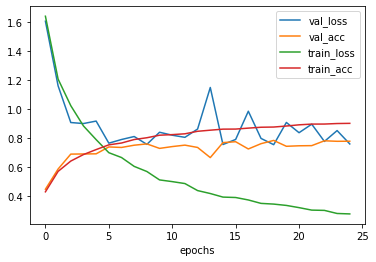

In [22]:
from matplotlib import pyplot as plt

if 'loss' in history.history:
  history.history['train_loss'] = history.history.pop('loss')
if 'acc' in history.history:
  history.history['train_acc'] = history.history.pop('acc')

pd.DataFrame(history.history).plot(xlabel='epochs')

plt.show()

In [15]:
test_loss,test_acc=model.evaluate(Xtest,ytest,batch_size=128)
print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

13/13 [==============================] - 1s 51ms/step - loss: 0.7064 - acc: 0.7742
The test loss is  0.7063896656036377
The best accuracy is:  77.4233877658844


In [16]:
model.save('drive/MyDrive/GTZAN/trained_model')

INFO:tensorflow:Assets written to: drive/MyDrive/GTZAN/trained_model/assets


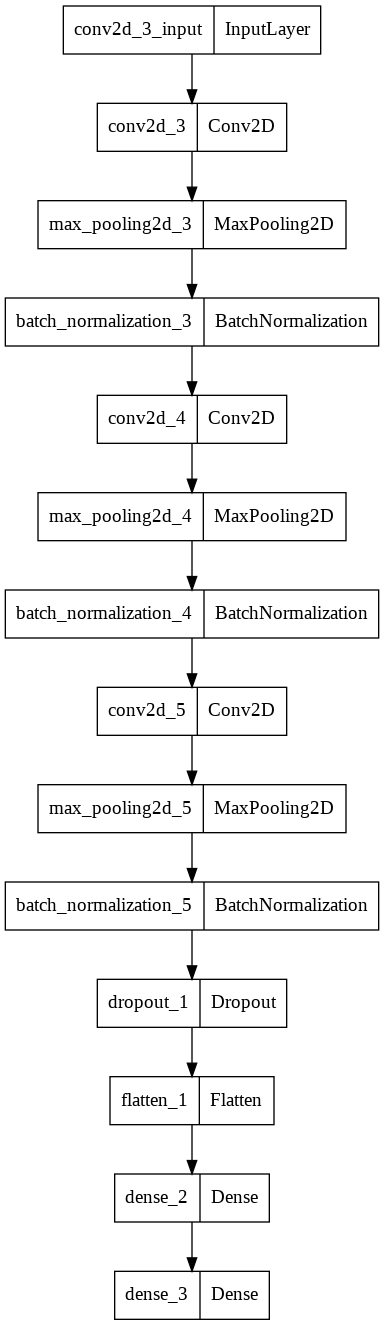

In [ ]:
dot_img_file = 'drive/MyDrive/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=False)